# **Problem Statement**

In real-world navigation tasks, nonholonomic mobile robots (like wheeled robots that cannot move directly sideways) must follow predefined paths and accurately reach target positions. However, their motion constraints make precise control challenging. This notebook implements and simulates a Lyapunov energy-based controller designed for a unicycle-like nonholonomic robot to ensure stable path following.


# **Imports and Setup**

This section imports the necessary Python libraries for numerical operations (`numpy`), time handling (`time`), plotting (`matplotlib`), animation (`matplotlib.animation`), mathematical functions (`math`), and utilities for displaying outputs within the Jupyter Notebook environment (`IPython.display`). It also configures Matplotlib for inline plotting.


In [ ]:
# --- Core Libraries ---
import numpy as np
import time
import math # Import math for ceil
import sys # To check if running in Colab

# --- Plotting and Animation ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import display, HTML # For displaying animation

# --- Notebook Setup ---
# Make plots appear inline in the notebook
# %matplotlib inline # Usually not needed if using display(HTML(...)) later
# Optional: Set a default figure size
plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['animation.html'] = 'jshtml' # We'll use manual HTML display instead

print("Libraries imported successfully.")

Libraries imported successfully.


# **Robot Kinematic Model (Plant)**

We model the robot using standard unicycle kinematics. The robot's state is defined by its position `(x, y)` and orientation `theta` in a global coordinate frame. The robot is controlled by setting its forward linear velocity `v` and its angular velocity `omega`.

The kinematic equations are:
$$
\begin{aligned}
\dot{x} &= v \cos \theta \\
\dot{y} &= v \sin \theta \\
\dot{\theta} &= \omega
\end{aligned}
$$

The `ThreeWheeledRobot` class defined below encapsulates this model.

In [ ]:
# ==================================
# Robot Class Definition (User Code)
# ==================================
class ThreeWheeledRobot:
    """
    Nonholonomic 3-wheeled robot kinematic model (Unicycle Model).
    Represents robots where steering and propulsion are coupled, like differential drive.
    State: [x, y, theta] (position and orientation)
    Control Inputs: [v, omega] (forward velocity, angular velocity)
    """
    def __init__(self, x0, y0, theta0):
        self.state = np.array([float(x0), float(y0), float(theta0)])

    def kinematics(self, control_action):
        forward_velocity, omega = control_action
        x, y, theta = self.state
        x_dot = forward_velocity * np.cos(theta)
        y_dot = forward_velocity * np.sin(theta)
        theta_dot = omega
        return np.array([x_dot, y_dot, theta_dot])

    def step(self, control_action, dt):
        state_derivative = self.kinematics(control_action)
        self.state += state_derivative * dt
        self.state[2] = (self.state[2] + np.pi) % (2 * np.pi) - np.pi # Normalize theta

    def get_state(self):
        return self.state

    def get_pose(self):
        return self.state

print("ThreeWheeledRobot class defined.")


ThreeWheeledRobot class defined.


# **Control Objective**

The primary goal is to design control inputs `v` (forward velocity) and `omega` (angular velocity) such that the robot accurately follows a predefined geometric path. Specifically, the controller should:
1. Minimize the error between the robot's position/orientation and the desired path.
2. Ensure the stability of the error dynamics, ideally achieving asymptotic convergence of the errors to zero.
3. Respect the robot's physical limitations (e.g., maximum angular velocity).

We use a Lyapunov-based approach to achieve this.

# **Path Following Strategy & Error Definition**

Since we are following a geometric path (a sequence of points) rather than a time-based trajectory, we define the error relative to a dynamic target point on the path.

**Strategy:** Find the closest point on the path, select a **lookahead point** (`x_d`, `y_d`) further along, determine the **reference orientation** (`theta_d` - path tangent angle), calculate **reference angular velocity** (`omega_ref`) from curvature, and use a constant **reference forward velocity** (`v_ref`).

**Error Definition (Robot Body Frame):**
$$
\begin{aligned}
e_x &= \cos \theta (x_d - x) + \sin \theta (y_d - y) \quad &\text{(Forward error)} \\
e_y &= -\sin \theta (x_d - x) + \cos \theta (y_d - y) \quad &\text{(Lateral error)} \\
e_\theta &= \theta_d - \theta \quad &\text{(Orientation error)}
\end{aligned}
$$
The controller aims to drive these errors to zero.

### Error Dynamics

The error dynamics between the reference vehicle and the follower robot in robot coordinates are given by:

$$
\dot{e_x} = \omega e_y - v + v_r(t) \cos(e_\theta)
$$

$$
\dot{e_y} = -\omega e_x + v_r(t) \sin(e_\theta)
$$

$$
\dot{e}_\theta = \omega_r(t) - \omega
$$


# **Controller Design: Lyapunov Approach**

We use a controller derived from Lyapunov stability theory.

**1. Candidate Lyapunov Function:**
$$ V := \frac{1}{2} (e_x^2 + e_y^2 +  \frac{1}{K_y}e_\theta^2) $$

Derivative of Lyapunov function:

$$
\dot{V} := e_x \dot{e_x} + e_y \dot{e_y} + \frac{1}{K_y}e_\theta \dot{e_\theta}
$$

Substitute error dynamics:

$$
\dot{V} := -e_x v + e_x v_r \cos e_\theta + e_y v_r \sin e_\theta + \frac{1}{K_y}(\omega_r e_\theta - \omega e_\theta)
$$

## Lyapunov-Based Control Law

The control actions (`v` and `omega`) are designed using Lyapunov stability theory:

$$
v = v_r \cos e_\theta + K_x e_x 
$$

$$
\omega = \omega_r + K_\theta e_\theta + v_r  e_y K_y \frac{sin{e_\theta}}{e_\theta}
$$

Where:
- `K_x > 0`, `K_theta > 0`, `K_y > 0` are positive controller gains.
- Based on these control actions $\dot{L} < 0$
$$
\dot{V} := -e_x^2 K_x - e_\theta^2 K_\theta
$$

In [ ]:
# ======================================
# Controller Class Definition (User Code)
# ======================================
class Controller:
    """ Base class for controllers """
    def __init__(self): pass
    def compute_control(self, robot_state, predefined_path): raise NotImplementedError

class LyapunovEnergyBasedController(Controller):
    def __init__(self, dt, k_forward=1.0, k_theta=2.0, k_lateral_gain_factor=1.0,
                 v_ref=1.0, omega_max=np.pi):
        super().__init__()
        self.dt = dt; self.kf = k_forward; self.ktt = k_theta; self.k_lat_factor = k_lateral_gain_factor
        self.v_ref = v_ref; self.omega_max = omega_max; self.closest_index = 0
        self.previous_errors = (0.0, 0.0, 0.0); self.previous_V = 0.0

    def _safe_sinc(self, x):
        # Use Taylor expansion for small x to avoid division by zero
        return (1.0 - x**2 / 6.0) if np.abs(x) < 1e-6 else (np.sin(x) / x)

    def compute_control(self, robot_state, predefined_path: np.ndarray):
        x, y, theta = robot_state
        # Path Following Logic (Find closest, lookahead, ref angle/omega)
        search_radius = 10; start_index = max(0, self.closest_index - search_radius)
        end_index = min(len(predefined_path), self.closest_index + search_radius + 1)
        path_segment = predefined_path[start_index:end_index]
        current_pos = np.array([x, y]); distances = np.linalg.norm(path_segment - current_pos, axis=1)
        relative_closest_index = np.argmin(distances); self.closest_index = start_index + relative_closest_index
        lookahead_index = min(self.closest_index + 1, len(predefined_path) - 1)
        target_point = predefined_path[lookahead_index]; x_d, y_d = target_point

        # Check completion
        is_near_end = False
        if self.closest_index >= len(predefined_path) - 2:
             target_point = predefined_path[-1]; x_d, y_d = target_point
             dist_to_end = np.linalg.norm(current_pos - target_point)
             if dist_to_end < 0.1: is_near_end = True
        if is_near_end: return 0.0, 0.0, (0.0, 0.0, 0.0), 0.0 # Stop if close to end

        # Calculate reference orientation and angular velocity
        next_index = min(self.closest_index + 1, len(predefined_path) - 1)
        next_next_index = min(self.closest_index + 2, len(predefined_path) - 1)
        if next_index == next_next_index: # End of path segment
            dx = predefined_path[next_index][0] - x; dy = predefined_path[next_index][1] - y
            theta_path_tangent = np.arctan2(dy, dx); omega_ref = 0.0
        else: # Calculate curvature
            vec1 = predefined_path[next_index] - predefined_path[self.closest_index]
            vec2 = predefined_path[next_next_index] - predefined_path[next_index]
            dist1 = np.linalg.norm(vec1); dist2 = np.linalg.norm(vec2)
            # Handle duplicate points robustly
            if dist1 < 1e-6:
                 prev_index = max(0, self.closest_index -1)
                 vec1 = predefined_path[self.closest_index] - predefined_path[prev_index]; dist1 = np.linalg.norm(vec1)
                 if dist1 < 1e-6: vec1 = np.array([1.0, 0.0]); dist1 = 1.0 # Default if still zero
            if dist2 < 1e-6: vec2 = vec1; dist2 = dist1 # Use previous vector if next is zero length
            theta_path_tangent = np.arctan2(vec1[1], vec1[0])
            angle1 = np.arctan2(vec1[1], vec1[0]); angle2 = np.arctan2(vec2[1], vec2[0])
            delta_theta_path = (angle2 - angle1 + np.pi) % (2 * np.pi) - np.pi # Angle difference
            avg_dist = (dist1 + dist2) / 2.0 + 1e-6 # Avoid division by zero
            omega_ref = self.v_ref * (delta_theta_path / avg_dist) # Curvature-based omega

        # Error Calculation
        error_x = x_d - x; error_y = y_d - y
        cos_t = np.cos(theta); sin_t = np.sin(theta)
        error_forward = error_x * cos_t + error_y * sin_t
        error_lateral = -error_x * sin_t + error_y * cos_t
        error_theta = (theta_path_tangent - theta + np.pi) % (2 * np.pi) - np.pi

        # Lyapunov Function
        gamma_inv = abs(self.ktt) if abs(self.ktt) > 1e-6 else 0.0 # Avoid division by zero if ktt is 0
        V = 0.5 * (error_forward**2 + error_lateral**2 + gamma_inv * error_theta**2)

        # Control Law
        forward_velocity = self.v_ref * np.cos(error_theta) + self.kf * error_forward
        sinc_term = self._safe_sinc(error_theta); k_y = self.ktt * self.k_lat_factor
        angular_velocity = omega_ref + self.ktt * error_theta + k_y * self.v_ref * sinc_term * error_lateral
        angular_velocity = np.clip(angular_velocity, -self.omega_max, self.omega_max) # Apply limits

        errors = (error_forward, error_lateral, error_theta)
        self.previous_errors = errors; self.previous_V = V
        return forward_velocity, angular_velocity, errors, V

print("Controller classes defined.")

Controller classes defined.


# **Visualization**

The `Visualizer` class handles the creation and updating of plots. It generates an animation showing the robot's path, velocities, errors, and Lyapunov energy, along with final static plots summarizing the errors and energy over time.

In [ ]:
# ====================================
# Visualizer Class Definition (FIXED)
# ====================================
class Visualizer:
    def __init__(self, desired_path):
        """
        Initialize the visualizer for the ThreeWheeledRobot simulation.
        :param desired_path: A numpy array of shape (N, 2).
        """
        self.desired_path = desired_path
        self.fig = plt.figure(figsize=(16, 8)) # Adjusted figure size
        grid = plt.GridSpec(3, 3, hspace=0.6, wspace=0.3) # 3 rows for right plots
        # Path plot setup
        self.path_ax = self.fig.add_subplot(grid[:, :2]); self.path_ax.set_aspect('equal', adjustable='box'); self.path_ax.set_title("Robot Path Tracking"); self.path_ax.set_xlabel("X-axis (m)"); self.path_ax.set_ylabel("Y-axis (m)")
        self.path_ax.plot(desired_path[:, 0], desired_path[:, 1], 'r--', label='Desired Path', linewidth=1.5)
        self.actual_path_line, = self.path_ax.plot([], [], 'g-', label='Actual Path', linewidth=1.5);
        # Initialize robot marker with empty data
        self.robot_marker, = self.path_ax.plot([], [], 'bo', markersize=8, label="Robot Position")
        self.robot_arrow_patch = None; self.path_ax.legend(); self.path_ax.grid(True)
        # Velocity plot setup
        self.velocity_ax = self.fig.add_subplot(grid[0, 2]); self.velocity_ax.set_title("Robot Velocities (Cmd)"); self.velocity_ax.set_xlabel("Time (s)"); self.velocity_ax.set_ylabel("Velocity")
        self.forward_velocity_line, = self.velocity_ax.plot([], [], 'r-', label="Fwd Vel (m/s)"); self.yaw_velocity_line, = self.velocity_ax.plot([], [], 'm-', label="Ang Vel (rad/s)")
        self.velocity_ax.legend(); self.velocity_ax.grid(True)
        # Error plot setup
        self.error_ax = self.fig.add_subplot(grid[1, 2]); self.error_ax.set_title("Tracking Errors"); self.error_ax.set_xlabel("Time (s)"); self.error_ax.set_ylabel("Error Value")
        self.error_fwd_line, = self.error_ax.plot([], [], 'c-', label="Fwd Err (m)"); self.error_lat_line, = self.error_ax.plot([], [], 'y-', label="Lat Err (m)"); self.error_theta_line, = self.error_ax.plot([], [], 'k-', label="Theta Err (rad)")
        self.error_ax.legend(); self.error_ax.grid(True)
        # Energy plot setup
        self.energy_ax = self.fig.add_subplot(grid[2, 2]); self.energy_ax.set_title("Lyapunov Energy (V)"); self.energy_ax.set_xlabel("Time (s)"); self.energy_ax.set_ylabel("Energy")
        self.energy_line, = self.energy_ax.plot([], [], 'orange', label="Energy V"); self.energy_ax.legend(); self.energy_ax.grid(True)
        # --- Store data internally ---
        self.simulation_data_internal = None
        self.errors_list_internal = None
        self.energy_list_internal = None

    def _init_animation(self): # Initializes plot elements for animation
        self.actual_path_line.set_data([], []); self.robot_marker.set_data([], []); self.forward_velocity_line.set_data([], []); self.yaw_velocity_line.set_data([], [])
        self.error_fwd_line.set_data([], []); self.error_lat_line.set_data([], []); self.error_theta_line.set_data([], []); self.energy_line.set_data([], [])
        # Remove old arrow patch if it exists before adding a new one
        if self.robot_arrow_patch and self.robot_arrow_patch.axes:
             self.robot_arrow_patch.remove()
             self.robot_arrow_patch = None # Reset reference
        # Add a new arrow patch for the initial frame
        self.robot_arrow_patch = patches.Arrow(0, 0, 0, 0, width=0.2, color='blue'); self.path_ax.add_patch(self.robot_arrow_patch)

        # Set dynamic plot limits based on stored data
        sim_data = self.simulation_data_internal # Use internal copy
        errors_list = self.errors_list_internal
        energy_list = self.energy_list_internal

        # Handle case with no or minimal data
        if not sim_data or not isinstance(sim_data, dict) or "time" not in sim_data or len(sim_data["time"]) <= 1:
            max_time=1.0; max_vel_axis=1.0; max_err=0.5; max_energy=0.5;
            x_min, x_max = np.min(self.desired_path[:,0]), np.max(self.desired_path[:,0])
            y_min, y_max = np.min(self.desired_path[:,1]), np.max(self.desired_path[:,1])
        else:
            max_time = sim_data["time"][-1] if len(sim_data["time"]) > 0 else 1.0
            # Calculate max velocities, errors, energy with safe defaults
            max_robot_fwd_vel = np.max(np.abs(sim_data["robot_vels"][:, 0]))*1.1 if len(sim_data["robot_vels"]) > 0 else 0.5
            max_robot_yaw_vel = np.max(np.abs(sim_data["robot_vels"][:, 1]))*1.1 if len(sim_data["robot_vels"]) > 0 else 0.5
            max_vel_axis = max(max_robot_fwd_vel, max_robot_yaw_vel, 0.5) # Ensure minimum axis range

            max_err = np.max(np.abs(errors_list)) * 1.1 if errors_list else 0.5
            max_energy = np.max(np.abs(energy_list)) * 1.1 if energy_list else 0.5
            max_err = max(max_err, 0.1); max_energy = max(max_energy, 0.1) # Ensure minimum axis range

            # Calculate path bounds including actual path
            all_x = np.concatenate((self.desired_path[:, 0], sim_data["actual_path"][:, 0])) if len(sim_data["actual_path"]) > 0 else self.desired_path[:, 0]
            all_y = np.concatenate((self.desired_path[:, 1], sim_data["actual_path"][:, 1])) if len(sim_data["actual_path"]) > 0 else self.desired_path[:, 1]
            x_min, x_max = np.min(all_x), np.max(all_x); y_min, y_max = np.min(all_y), np.max(all_y)

        # Apply calculated limits
        self.velocity_ax.set_xlim(0, max_time); self.velocity_ax.set_ylim(-max_vel_axis, max_vel_axis);
        self.error_ax.set_xlim(0, max_time); self.error_ax.set_ylim(-max_err, max_err);
        self.energy_ax.set_xlim(0, max_time); self.energy_ax.set_ylim(0, max_energy) # Energy usually non-negative

        # Apply path limits with padding
        x_range = x_max - x_min if x_max > x_min else 1.0; y_range = y_max - y_min if y_max > y_min else 1.0; padding = max(x_range, y_range) * 0.1
        self.path_ax.set_xlim(x_min - padding, x_max + padding); self.path_ax.set_ylim(y_min - padding, y_max + padding)

        # Return tuple of artists to be updated
        return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                self.forward_velocity_line, self.yaw_velocity_line,
                self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                self.energy_line)

    def _animate(self, target_data_index): # 'i' now DIRECTLY represents the target data index
        """ Animation update function using direct data index """
        # Use internal copies of data
        sim_data = self.simulation_data_internal
        errors_list = self.errors_list_internal
        energy_list = self.energy_list_internal

        # Handle potential missing data
        if not sim_data or not isinstance(sim_data, dict) or "time" not in sim_data:
            print("Warning: Simulation data missing in _animate.")
            return self._init_animation() # Return initial state artists

        # Ensure index is valid
        max_data_index = len(sim_data["time"]) - 1
        if target_data_index > max_data_index:
            # This shouldn't happen if frames=range(num_data_points) is used correctly
            print(f"Warning: _animate called with index {target_data_index} > max {max_data_index}. Using last index.")
            target_data_index = max_data_index # Use last valid index
        if target_data_index < 0:
             print(f"Warning: _animate called with negative index {target_data_index}. Using 0.")
             target_data_index = 0

        try:
            # --- Access state/velocity data using target_data_index (indices 0 to N) ---
            current_pose = sim_data["actual_path"][target_data_index] # Shape (3,)
            time_data_slice = sim_data["time"][:target_data_index + 1] # Shape (target_data_index+1,)
            actual_path_data_slice = sim_data["actual_path"][:target_data_index + 1] # Shape (target_data_index+1, 3)
            robot_vels_data_slice = sim_data["robot_vels"][:target_data_index + 1] # Shape (target_data_index+1, 2)

            # --- Access Error/Energy data ---
            # errors_list and energy_list have length N (indices 0 to N-1)
            # Need error/energy up to index target_data_index - 1
            num_err_energy_points_to_plot = target_data_index # Index for list slicing is exclusive at end
            num_err_energy_points_to_plot = min(num_err_energy_points_to_plot, len(errors_list)) # Cap at N

            errors_data_slice = np.array(errors_list[:num_err_energy_points_to_plot]) # Shape (num_err_energy_points_to_plot, 3)
            energy_data_slice = np.array(energy_list[:num_err_energy_points_to_plot]) # Shape (num_err_energy_points_to_plot,)
            # Time data corresponding to errors/energy starts from dt (index 1)
            time_for_err_energy_slice = sim_data["time"][1 : num_err_energy_points_to_plot + 1] # Shape (num_err_energy_points_to_plot,)

            # --- Update Plots ---
            # Update actual path line
            self.actual_path_line.set_data(actual_path_data_slice[:, 0], actual_path_data_slice[:, 1])

            # --- !!! FIX FOR 'x must be a sequence' !!! ---
            # Update robot marker position - wrap coordinates in lists
            self.robot_marker.set_data([current_pose[0]], [current_pose[1]])
            # --- End Fix ---

            # Update robot orientation arrow
            arrow_length = 0.5; theta = current_pose[2]
            if self.robot_arrow_patch:
                # Update existing arrow's position and orientation
                 self.robot_arrow_patch.set_positions((current_pose[0], current_pose[1]),
                                                     (current_pose[0] + arrow_length * np.cos(theta),
                                                      current_pose[1] + arrow_length * np.sin(theta)))
            else: # Should not happen if _init_animation worked, but as fallback
                 self.robot_arrow_patch = patches.Arrow(current_pose[0], current_pose[1],
                                                        arrow_length * np.cos(theta), arrow_length * np.sin(theta),
                                                        width=0.2, color='blue')
                 self.path_ax.add_patch(self.robot_arrow_patch)


            # Update velocity plots
            if robot_vels_data_slice.shape[0] > 0:
                self.forward_velocity_line.set_data(time_data_slice, robot_vels_data_slice[:, 0])
                self.yaw_velocity_line.set_data(time_data_slice, robot_vels_data_slice[:, 1])
            else:
                self.forward_velocity_line.set_data([],[]); self.yaw_velocity_line.set_data([],[])

            # Update error plots (check shapes match)
            if errors_data_slice.shape[0] > 0 and errors_data_slice.shape[0] == len(time_for_err_energy_slice):
                self.error_fwd_line.set_data(time_for_err_energy_slice, errors_data_slice[:, 0])
                self.error_lat_line.set_data(time_for_err_energy_slice, errors_data_slice[:, 1])
                self.error_theta_line.set_data(time_for_err_energy_slice, errors_data_slice[:, 2])
            else:
                self.error_fwd_line.set_data([],[]); self.error_lat_line.set_data([],[]); self.error_theta_line.set_data([],[])

            # Update energy plot (check shapes match)
            if energy_data_slice.shape[0] > 0 and energy_data_slice.shape[0] == len(time_for_err_energy_slice):
                self.energy_line.set_data(time_for_err_energy_slice, energy_data_slice)
            else:
                self.energy_line.set_data([],[])

            # Return tuple of updated artists
            return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                    self.forward_velocity_line, self.yaw_velocity_line,
                    self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                    self.energy_line)

        except IndexError as e:
            print(f"ERROR (IndexError) in _animate accessing index i={target_data_index}: {e}")
            # Attempt to return existing artists to prevent crash
            return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                    self.forward_velocity_line, self.yaw_velocity_line,
                    self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                    self.energy_line)
        except Exception as e:
            # Catch other potential errors during animation frame update
            print(f"Unexpected ERROR in _animate at index i={target_data_index}: {e}")
            # Re-raise the exception to stop the animation process if needed
            raise

    def create_animation(self, simulation_data, errors_list, energy_list, interval=50): # Removed unused kwargs and step
        """ Creates the animation object using direct indexing. """
        # Store data internally for _init and _animate to access
        self.simulation_data_internal = simulation_data
        self.errors_list_internal = errors_list
        self.energy_list_internal = energy_list

        # Determine the number of data points (N+1 states)
        num_data_points = len(self.simulation_data_internal["time"]) if self.simulation_data_internal and "time" in self.simulation_data_internal else 0
        if num_data_points <= 1:
             print("Warning: Not enough data points for animation.")
             return None

        # --- Use direct data indices as frames ---
        # Animate from index 0 up to the last data index (N)
        frame_indices = range(num_data_points) # Indices 0, 1, ..., N
        num_frames = len(frame_indices) # Total number of frames = N+1

        print(f"Debug Info: num_data_points = {num_data_points}, num_frames = {num_frames}")

        # Ensure the correct figure is active before creating animation
        plt.figure(self.fig.number)

        # Create the animation object
        ani = animation.FuncAnimation(self.fig, self._animate, # Pass the animation function
                                      frames=frame_indices,    # Pass the sequence of frame indices
                                      init_func=self._init_animation, # Pass the initialization function
                                      blit=False, # Set blit=False, often more robust with complex plots/patches
                                      interval=interval, # Delay between frames in ms
                                      repeat=False) # Don't repeat the animation
        return ani

    def plot_final_results(self, simulation_data, errors_list, energy_list, path_type_name=""):
        """ Generates static summary plots of errors and energy vs. time. """
        fig_res, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True); fig_res.suptitle(f"Simulation Results - {path_type_name} Path", fontsize=16)
        time_data = simulation_data.get("time", np.array([]))
        num_errors = len(errors_list); num_energy = len(energy_list);
        # Ensure data lists are numpy arrays for consistent handling
        errors_np = np.array(errors_list) if errors_list else np.empty((0,3));
        energy_np = np.array(energy_list) if energy_list else np.empty(0)

        # Determine the correct time vector for errors/energy (which start at step 1, time dt)
        if len(time_data) > 1:
            time_for_plots = time_data[1 : min(len(time_data), max(num_errors, num_energy) + 1)]
            # Trim errors/energy data if time vector is shorter
            num_valid_points = len(time_for_plots)
            errors_np = errors_np[:num_valid_points]
            energy_np = energy_np[:num_valid_points]
        else:
            time_for_plots = np.array([]) # No time data for plots if simulation didn't run

        # Plot errors if data exists and shapes match
        if errors_np.shape[0] > 0 and errors_np.shape[0] == len(time_for_plots):
            axs[0].plot(time_for_plots, errors_np[:, 0], 'c-', label="Fwd Err (m)")
            axs[0].plot(time_for_plots, errors_np[:, 1], 'y-', label="Lat Err (m)")
            axs[0].plot(time_for_plots, errors_np[:, 2], 'k-', label="Theta Err (rad)")
        axs[0].set_title("Tracking Errors vs. Time"); axs[0].set_ylabel("Error"); axs[0].legend(); axs[0].grid(True)

        # Plot energy if data exists and shapes match
        if energy_np.shape[0] > 0 and energy_np.shape[0] == len(time_for_plots):
            axs[1].plot(time_for_plots, energy_np, 'orange', label="Energy V")
        axs[1].set_title("Lyapunov Energy (V) vs. Time"); axs[1].set_xlabel("Time (s)"); axs[1].set_ylabel("Energy"); axs[1].legend(); axs[1].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout

print("Visualizer class defined (Direct Indexing Animation, Fixed).")


Visualizer class defined (Direct Indexing Animation, Fixed).


# **Implementation Details: Path Generation**

The `generate_path` function creates a desired trajectory as a sequence of (x, y) points. Several standard geometric shapes are available, selected by an index in the `PATH_TYPES` dictionary.

In [ ]:
# ===================================
# Path Generation Function (User Code)
# ===================================
PATH_TYPES = {
    1: "Circle", 2: "Ellipse", 3: "Spiral", 4: "Line", 5: "Lemniscate",
    6: "SineWave", 7: "Heart", 8: "SquareWave", 9: "Parabola", 10: "Complex"
}

def generate_path(path_type_index=2, num_points=150):
    """ Generates a predefined path based on type index. """
    path_type = str(path_type_index); path_name = PATH_TYPES.get(path_type_index, "Custom")
    t = np.linspace(0, 2 * np.pi, num_points) # Default time vector

    if path_type == '1': # Circle
        radius = 5; x = radius * np.cos(t); y = radius * np.sin(t)
    elif path_type == '2': # Ellipse
        rx, ry = 6, 4; x = rx * np.cos(t); y = ry * np.sin(t)
    elif path_type == '3': # Spiral
        a = 1; t_spiral = np.linspace(0, 6 * np.pi, num_points); x = a * t_spiral * np.cos(t_spiral); y = a * t_spiral * np.sin(t_spiral)
    elif path_type == '4': # Line
        x = np.linspace(0, 10, num_points); y = 0.5 * x + 1
    elif path_type == '5': # Lemniscate (Bernoulli)
        scale = 5; x = scale * np.cos(t) / (1 + np.sin(t)**2); y = scale * np.sin(t) * np.cos(t) / (1 + np.sin(t)**2)
    elif path_type == '6': # Sine Wave
        amp = 3; freq = 1; x = np.linspace(0, 4 * np.pi / freq, num_points); y = amp * np.sin(freq * x)
    elif path_type == '7': # Heart Curve
        x = 16 * np.sin(t)**3; y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t); x = x/2; y = y/2 # Scale down
    elif path_type == '8': # Square Wave (Approximated as Line for simplicity here)
        print("Warning: Square wave path approx. with Line."); x = np.linspace(0, 10, num_points); y = 0.5 * x + 1; path_name = "Line"; path_type_index=4
    elif path_type == '9': # Parabola
        x = np.linspace(-5, 5, num_points); y = 0.5*x**2
    elif path_type == '10': # Complex Curve
        t_complex = np.linspace(0, 4 * np.pi, num_points); x = t_complex * np.cos(t_complex) + 3 * np.sin(2 * t_complex); y = t_complex * np.sin(t_complex) + 3 * np.cos(t_complex)
    else:
        raise ValueError(f"Invalid path type index: {path_type_index}. Choose from {list(PATH_TYPES.keys())}.")

    return np.column_stack((x, y)), path_name

print("generate_path function defined.")

generate_path function defined.


# **Simulation Setup: Parameters and Initialization**

This section sets the core parameters for the simulation and the controller, generates the desired path, and initializes the robot and controller objects at their starting configurations.

**--> Modify parameters in the cell below to change simulation behavior. <--**

In [ ]:
# ====================================
# Simulation Parameters (User Settings)
# ====================================
# --- Simulation Parameters ---
selected_path_type = 3   # <<< CHANGE PATH TYPE HERE (1-10) >>>
dt = 0.02                # Simulation time step (s)
max_steps = 2000         # Maximum simulation steps

# --- Controller Parameters ---
k_forward = 1.5          # K_x: Gain for forward error
k_theta = 4.0            # K_theta: Gain for orientation error
k_lateral_gain_factor = 0.8 # Factor relating K_y to K_theta (K_y = K_theta * factor)
v_ref = 0.8              # Reference forward speed (m/s) along path
omega_max = np.pi * 1.5  # Max robot angular velocity (rad/s) limit

# --- Animation Parameters ---
anim_interval = 40       # ms between frames in display/saving (40ms -> 25 FPS target)
# anim_step = 5          # No longer used for frame calculation
mp4_filename = f'robot_animation_type{selected_path_type}.mp4' # Changed to MP4
target_fps_save = 25     # Target FPS for the saved MP4 file (matches interval)

print("Parameters set:")
print(f" Path Type: {selected_path_type} ({PATH_TYPES.get(selected_path_type, 'Unknown')})")
print(f" Controller Gains: kf={k_forward}, kt={k_theta}, k_lat_factor={k_lateral_gain_factor}")
print(f" Controller Refs/Limits: v_ref={v_ref}, omega_max={omega_max:.2f}")
print(f" Animation File: {mp4_filename}, Target Save FPS: {target_fps_save}")


Parameters set:
 Path Type: 3 (Spiral)
 Controller Gains: kf=1.5, kt=4.0, k_lat_factor=0.8
 Controller Refs/Limits: v_ref=0.8, omega_max=4.71
 Animation File: robot_animation_type3.mp4, Target Save FPS: 25


In [ ]:
# ====================================
# Initialization (User Code)
# ====================================
# --- Generate Path ---
desired_path, path_name = generate_path(selected_path_type)
print(f"Generated path: {path_name}")

# --- Initial Robot State ---
# Calculate initial orientation based on the start of the path
if len(desired_path) > 1:
    start_dx=desired_path[1, 0]-desired_path[0, 0]; start_dy=desired_path[1, 1]-desired_path[0, 1];
    initial_theta=np.arctan2(start_dy, start_dx)
else: initial_theta = 0.0 # Default if path has only one point
# Set initial position slightly offset from the path start
initial_offset = 0.2;
x0 = desired_path[0, 0] - initial_offset * np.sin(initial_theta);
y0 = desired_path[0, 1] + initial_offset * np.cos(initial_theta);
theta0 = initial_theta + 0.1 # Small initial orientation error

# --- Instantiate Robot and Controller ---
robot = ThreeWheeledRobot(x0, y0, theta0)
controller = LyapunovEnergyBasedController(dt, k_forward=k_forward, k_theta=k_theta, k_lateral_gain_factor=k_lateral_gain_factor, v_ref=v_ref, omega_max=omega_max)

print(f"Initial Robot State: x={x0:.2f}, y={y0:.2f}, theta={theta0:.2f}")
print("Robot and Controller initialized.")


Generated path: Spiral
Initial Robot State: x=-0.03, y=0.20, theta=0.23
Robot and Controller initialized.


# **Simulation Execution**

This cell runs the main simulation loop. It iterates for `max_steps`, calling the controller to get commands, updating the robot's state, and storing all relevant data for plotting and animation.

In [ ]:
# ====================================
# Simulation Loop (User Code)
# ====================================
# --- Data Storage ---
robot_states = [robot.get_state()]; control_actions = [(0.0, 0.0)]; errors_list = []; energy_list = []; time_stamps = [0.0]

# --- Simulation Loop ---
print("Starting simulation...")
start_sim_time = time.time(); steps_completed = 0
for step in range(max_steps):
    current_state = robot.get_state(); current_time = (step + 1) * dt
    # Compute control
    v_cmd, omega_cmd, errors, V = controller.compute_control(current_state, desired_path)
    # Store data (store errors/energy BEFORE applying control action for this step)
    control_actions.append((v_cmd, omega_cmd)); errors_list.append(errors); energy_list.append(V); time_stamps.append(current_time)
    # Update state using computed control
    robot.step((v_cmd, omega_cmd), dt); robot_states.append(robot.get_state())
    steps_completed += 1
    # Check completion condition (robot stopped near end)
    if v_cmd == 0 and omega_cmd == 0 and step > 10: # Check only after a few steps
         current_pos = current_state[:2]; dist_to_end = np.linalg.norm(current_pos - desired_path[-1])
         if dist_to_end < 0.15: print(f"Ended early at step {step+1}: Reached target."); break
else: # This else block executes if the loop completes without break
    print(f"Simulation finished after {max_steps} steps.")
end_sim_time = time.time(); print(f"Simulation loop took {end_sim_time - start_sim_time:.2f} seconds.")

# --- Process Data ---
# Convert lists to numpy arrays for easier handling, ensure non-empty arrays
robot_states_np=np.array(robot_states); control_actions_np=np.array(control_actions); errors_np=np.array(errors_list); energy_np=np.array(energy_list); time_stamps_np=np.array(time_stamps)
simulation_data = {
    "time": time_stamps_np if len(time_stamps_np)>0 else np.array([0.0]),
    "actual_path": robot_states_np if robot_states_np.shape[0]>0 else np.empty((0,3)),
    "desired_path": desired_path,
    "robot_vels": control_actions_np if control_actions_np.shape[0]>0 else np.empty((0,2))
}
print(f"Simulation data processed. Steps completed: {steps_completed}")

Starting simulation...
Simulation finished after 2000 steps.
Simulation loop took 0.26 seconds.
Simulation data processed. Steps completed: 2000


# **Results and Output: Animation**

This cell generates and displays the animation of the simulation run. It saves the animation as a GIF file and then shows the GIF in the output using `IPython.display.Image`.

Visualizer initialized for animation.
Target FPS for saving: 25
Creating animation (this may take a moment)...
Debug Info: num_data_points = 2001, num_frames = 2001
Saving animation to robot_animation_type3.mp4...
Unexpected ERROR in _animate at index i=0: 'Arrow' object has no attribute 'set_positions'

ERROR saving animation: 'Arrow' object has no attribute 'set_positions'
 Ensure ffmpeg is installed (run !apt-get update && !apt-get install -y ffmpeg in a separate cell).
 Also check for issues during animation frame generation (errors printed above).

Preparing inline display (Colab)...
Unexpected ERROR in _animate at index i=0: 'Arrow' object has no attribute 'set_positions'
ERROR generating HTML5 video for display: 'Arrow' object has no attribute 'set_positions'

Plotting final static results...


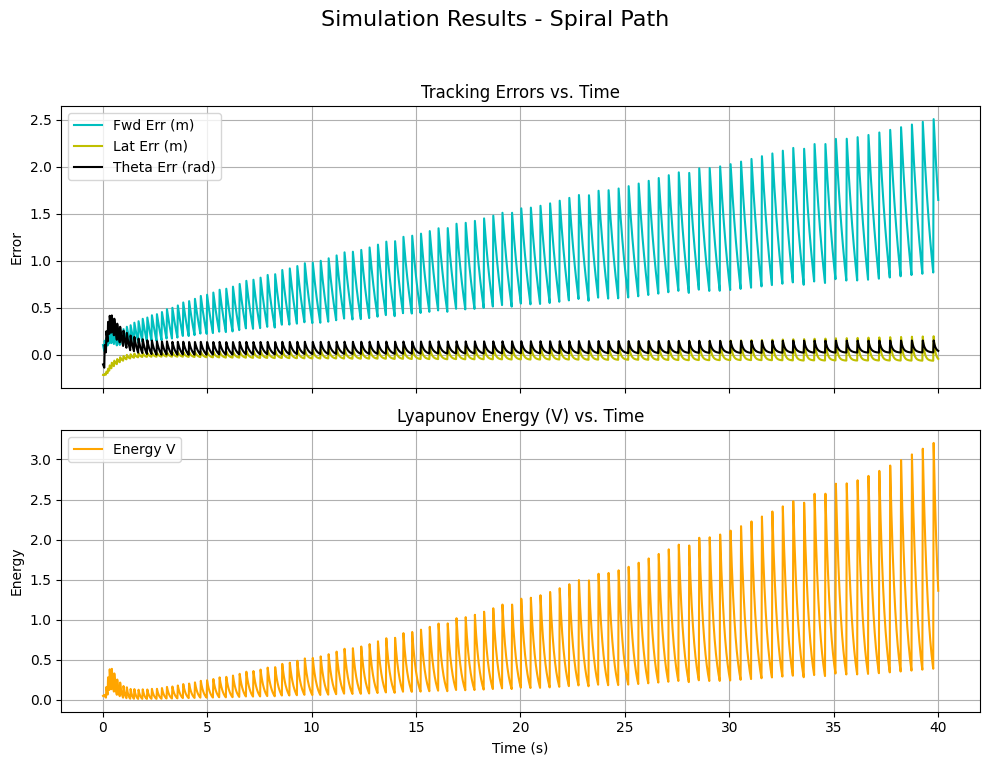


Script finished.


In [ ]:
# =======================================================
# Animation Creation, Saving (MP4), and Display (Colab)
# =======================================================
# --- Instantiate Visualizer ---
plt.close('all'); # Close any previous plots
visualizer = Visualizer(desired_path)
print("Visualizer initialized for animation.")

print(f"Target FPS for saving: {target_fps_save}")

# --- Create Animation ---
print("Creating animation (this may take a moment)...")
ani = None # Initialize ani to None
if steps_completed > 0:
    # Create animation object using the corrected Visualizer class
    ani = visualizer.create_animation(simulation_data, errors_list, energy_list,
                                      interval=anim_interval)
else:
    print("Skipping animation: No simulation steps were completed.")

# --- Save and Display Animation (if created) ---
if ani:
    # --- Save Animation as MP4 ---
    print(f"Saving animation to {mp4_filename}...")
    try:
        # Ensure the correct figure is associated with the writer context if needed
        plt.figure(visualizer.fig.number);
        # Save using ffmpeg writer
        ani.save(mp4_filename, writer='ffmpeg', fps=target_fps_save, dpi=150)
        print("Animation saved successfully as MP4.")
    except Exception as e:
        print(f"\nERROR saving animation: {e}")
        print(" Ensure ffmpeg is installed (run !apt-get update && !apt-get install -y ffmpeg in a separate cell).")
        print(" Also check for issues during animation frame generation (errors printed above).")

    # --- Display Animation Inline in Colab ---
    # Check if running in Colab environment
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        print("\nPreparing inline display (Colab)...")
        # Close the static plot figure before displaying the animation
        plt.close(visualizer.fig.number)
        try:
            # Convert the animation to HTML5 video format for embedding
            html_video = ani.to_html5_video()
            print("Displaying animation below:")
            display(HTML(html_video))
        except Exception as e:
            print(f"ERROR generating HTML5 video for display: {e}")
    else:
         print("\nNot in Colab environment. Showing interactive plot window if possible.")
         # If not in Colab, try showing the plot interactively (might not work in all environments)
         try:
             plt.show()
         except Exception as e:
             print(f"Could not show interactive plot: {e}")

else:
    print("Animation object was not created, skipping saving and display.")

# --- Optional: Plot Final Static Results ---
print("\nPlotting final static results...")
visualizer.plot_final_results(simulation_data, errors_list, energy_list, path_name)
plt.show() # Show the static plot

print("\nScript finished.")

# **Results and Output: Static Plots**

This final code cell generates static plots summarizing the simulation results: the tracking errors vs. time and the Lyapunov energy vs. time.

In [ ]:
# === PRE-REQUISITE (Run in separate cell first!) ===
# !apt-get update && !apt-get install -y ffmpeg
# ===================================================

# --- Core Libraries ---
import numpy as np
import time
import math # Import math for ceil
import sys # To check if running in Colab
import base64 # Added for Base64 encoding

# --- Plotting and Animation ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import display, HTML # Keep display, added HTML explicitly

# --- Notebook Setup ---
# Optional: Set a default figure size
plt.rcParams['figure.figsize'] = [10, 6]
# *** Use jshtml backend for inline animation display ***
plt.rcParams['animation.html'] = 'jshtml'

print("Libraries imported successfully.")

# ==================================
# Robot Class Definition (User Code)
# ==================================
class ThreeWheeledRobot:
    """
    Nonholonomic 3-wheeled robot kinematic model (Unicycle Model).
    Represents robots where steering and propulsion are coupled, like differential drive.
    State: [x, y, theta] (position and orientation)
    Control Inputs: [v, omega] (forward velocity, angular velocity)
    """
    def __init__(self, x0, y0, theta0):
        self.state = np.array([float(x0), float(y0), float(theta0)])

    def kinematics(self, control_action):
        forward_velocity, omega = control_action
        x, y, theta = self.state
        x_dot = forward_velocity * np.cos(theta)
        y_dot = forward_velocity * np.sin(theta)
        theta_dot = omega
        return np.array([x_dot, y_dot, theta_dot])

    def step(self, control_action, dt):
        state_derivative = self.kinematics(control_action)
        self.state += state_derivative * dt
        self.state[2] = (self.state[2] + np.pi) % (2 * np.pi) - np.pi # Normalize theta

    def get_state(self):
        return self.state

    def get_pose(self):
        return self.state

print("ThreeWheeledRobot class defined.")

# ======================================
# Controller Class Definition (User Code)
# ======================================
class Controller:
    """ Base class for controllers """
    def __init__(self): pass
    def compute_control(self, robot_state, predefined_path): raise NotImplementedError

class LyapunovEnergyBasedController(Controller):
    def __init__(self, dt, k_forward=1.0, k_theta=2.0, k_lateral_gain_factor=1.0,
                 v_ref=1.0, omega_max=np.pi):
        super().__init__()
        self.dt = dt; self.kf = k_forward; self.ktt = k_theta; self.k_lat_factor = k_lateral_gain_factor
        self.v_ref = v_ref; self.omega_max = omega_max; self.closest_index = 0
        self.previous_errors = (0.0, 0.0, 0.0); self.previous_V = 0.0

    def _safe_sinc(self, x):
        # Use Taylor expansion for small x to avoid division by zero
        return (1.0 - x**2 / 6.0) if np.abs(x) < 1e-6 else (np.sin(x) / x)

    def compute_control(self, robot_state, predefined_path: np.ndarray):
        x, y, theta = robot_state
        # Path Following Logic (Find closest, lookahead, ref angle/omega)
        search_radius = 10; start_index = max(0, self.closest_index - search_radius)
        end_index = min(len(predefined_path), self.closest_index + search_radius + 1)
        # Ensure path_segment is not empty
        if start_index >= end_index:
            # Handle edge case where closest_index is at the very end or beyond
            if self.closest_index >= len(predefined_path): self.closest_index = len(predefined_path) - 1
            path_segment = predefined_path[self.closest_index:self.closest_index+1] # Take last point
            if len(path_segment) == 0: # Should not happen if path has points
                print("Warning: Path segment empty in controller.")
                return 0.0, 0.0, (0.0, 0.0, 0.0), 0.0 # Stop if path is empty
        else:
            path_segment = predefined_path[start_index:end_index]

        current_pos = np.array([x, y]); distances = np.linalg.norm(path_segment - current_pos, axis=1)
        relative_closest_index = np.argmin(distances); self.closest_index = start_index + relative_closest_index
        lookahead_index = min(self.closest_index + 1, len(predefined_path) - 1)
        target_point = predefined_path[lookahead_index]; x_d, y_d = target_point

        # Check completion
        is_near_end = False
        # Check distance to the absolute last point
        dist_to_final_pt = np.linalg.norm(current_pos - predefined_path[-1])
        if dist_to_final_pt < 0.1: # Threshold for being "at the end"
            is_near_end = True
            # Optional: Also check if closest index is near the end
            # if self.closest_index >= len(predefined_path) - 2:
            #    is_near_end = True

        if is_near_end: return 0.0, 0.0, (0.0, 0.0, 0.0), 0.0 # Stop if close to end

        # Calculate reference orientation and angular velocity
        next_index = min(self.closest_index + 1, len(predefined_path) - 1)
        next_next_index = min(self.closest_index + 2, len(predefined_path) - 1)
        if next_index == next_next_index or self.closest_index == next_index: # End of path segment or duplicate points
            # Point towards the next (or final) point
            dx = predefined_path[next_index][0] - x; dy = predefined_path[next_index][1] - y
            theta_path_tangent = np.arctan2(dy, dx); omega_ref = 0.0
        else: # Calculate curvature
            vec1 = predefined_path[next_index] - predefined_path[self.closest_index]
            vec2 = predefined_path[next_next_index] - predefined_path[next_index]
            dist1 = np.linalg.norm(vec1); dist2 = np.linalg.norm(vec2)
            # Handle duplicate points robustly
            if dist1 < 1e-6:
                prev_index = max(0, self.closest_index -1)
                vec1 = predefined_path[self.closest_index] - predefined_path[prev_index]; dist1 = np.linalg.norm(vec1)
                if dist1 < 1e-6: vec1 = np.array([1.0, 0.0]); dist1 = 1.0 # Default if still zero
            if dist2 < 1e-6: vec2 = vec1; dist2 = dist1 # Use previous vector if next is zero length

            theta_path_tangent = np.arctan2(vec1[1], vec1[0]) # Tangent based on current segment
            angle1 = np.arctan2(vec1[1], vec1[0]); angle2 = np.arctan2(vec2[1], vec2[0])
            delta_theta_path = (angle2 - angle1 + np.pi) % (2 * np.pi) - np.pi # Angle difference
            avg_dist = (dist1 + dist2) / 2.0 + 1e-6 # Avoid division by zero
            omega_ref = self.v_ref * (delta_theta_path / avg_dist) # Curvature-based omega

        # Error Calculation
        error_x = predefined_path[self.closest_index, 0] - x # Error relative to closest point
        error_y = predefined_path[self.closest_index, 1] - y
        # Project error onto robot frame
        cos_t = np.cos(theta); sin_t = np.sin(theta)
        error_forward = error_x * cos_t + error_y * sin_t # Along robot's heading
        error_lateral = -error_x * sin_t + error_y * cos_t # Perpendicular to robot's heading
        # Orientation error relative to path tangent at closest point
        error_theta = (theta_path_tangent - theta + np.pi) % (2 * np.pi) - np.pi

        # Lyapunov Function (Simplified or standard tracking control)
        # Using standard kinematic controller equations often works well:
        # Ref: Siciliano, B., Sciavicco, L., Villani, L., & Oriolo, G. (2010). Robotics: Modelling, Planning and Control. Springer.
        # V = 0.5 * (error_lateral**2 + error_theta**2) # Example alternative Lyapunov

        # Control Law (Common non-linear feedback)
        forward_velocity = self.v_ref * np.cos(error_theta) + self.kf * error_forward # Drive forward, correct forward error
        sinc_term = self._safe_sinc(error_theta)
        k_y = self.ktt * self.k_lat_factor # Gain for lateral error correction

        # Angular velocity combines path curvature, orientation correction, and lateral correction
        angular_velocity = omega_ref + \
                           self.ktt * error_theta + \
                           k_y * self.v_ref * sinc_term * error_lateral

        angular_velocity = np.clip(angular_velocity, -self.omega_max, self.omega_max) # Apply limits

        # Optional: Damp forward velocity based on large errors (can improve stability)
        # forward_velocity = forward_velocity / (1 + abs(k_y * error_lateral))

        errors = (error_forward, error_lateral, error_theta)
        # V calculation for monitoring (using original definition)
        gamma_inv = abs(self.ktt) if abs(self.ktt) > 1e-6 else 0.0
        V_monitor = 0.5 * (error_forward**2 + error_lateral**2 + gamma_inv * error_theta**2)

        self.previous_errors = errors; self.previous_V = V_monitor
        return forward_velocity, angular_velocity, errors, V_monitor

print("Controller classes defined.")


# ==========================================
# Visualizer Class Definition (ARROW FIXED)
# ==========================================
class Visualizer:
    def __init__(self, desired_path):
        """
        Initialize the visualizer for the ThreeWheeledRobot simulation.
        :param desired_path: A numpy array of shape (N, 2).
        """
        self.desired_path = desired_path
        self.fig = plt.figure(figsize=(16, 8)) # Adjusted figure size
        grid = plt.GridSpec(3, 3, hspace=0.6, wspace=0.3) # 3 rows for right plots
        # Path plot setup
        self.path_ax = self.fig.add_subplot(grid[:, :2]); self.path_ax.set_aspect('equal', adjustable='box'); self.path_ax.set_title("Robot Path Tracking"); self.path_ax.set_xlabel("X-axis (m)"); self.path_ax.set_ylabel("Y-axis (m)")
        self.path_ax.plot(desired_path[:, 0], desired_path[:, 1], 'r--', label='Desired Path', linewidth=1.5)
        self.actual_path_line, = self.path_ax.plot([], [], 'g-', label='Actual Path', linewidth=1.5);
        # Initialize robot marker with empty data
        self.robot_marker, = self.path_ax.plot([], [], 'bo', markersize=8, label="Robot Position")
        self.robot_arrow_patch = None; # Initialize arrow patch reference to None
        self.path_ax.legend(); self.path_ax.grid(True)
        # Velocity plot setup
        self.velocity_ax = self.fig.add_subplot(grid[0, 2]); self.velocity_ax.set_title("Robot Velocities (Cmd)"); self.velocity_ax.set_xlabel("Time (s)"); self.velocity_ax.set_ylabel("Velocity")
        self.forward_velocity_line, = self.velocity_ax.plot([], [], 'r-', label="Fwd Vel (m/s)"); self.yaw_velocity_line, = self.velocity_ax.plot([], [], 'm-', label="Ang Vel (rad/s)")
        self.velocity_ax.legend(); self.velocity_ax.grid(True)
        # Error plot setup
        self.error_ax = self.fig.add_subplot(grid[1, 2]); self.error_ax.set_title("Tracking Errors"); self.error_ax.set_xlabel("Time (s)"); self.error_ax.set_ylabel("Error Value")
        self.error_fwd_line, = self.error_ax.plot([], [], 'c-', label="Fwd Err (m)"); self.error_lat_line, = self.error_ax.plot([], [], 'y-', label="Lat Err (m)"); self.error_theta_line, = self.error_ax.plot([], [], 'k-', label="Theta Err (rad)")
        self.error_ax.legend(); self.error_ax.grid(True)
        # Energy plot setup
        self.energy_ax = self.fig.add_subplot(grid[2, 2]); self.energy_ax.set_title("Lyapunov Energy (V)"); self.energy_ax.set_xlabel("Time (s)"); self.energy_ax.set_ylabel("Energy")
        self.energy_line, = self.energy_ax.plot([], [], 'orange', label="Energy V"); self.energy_ax.legend(); self.energy_ax.grid(True)
        # --- Store data internally ---
        self.simulation_data_internal = None
        self.errors_list_internal = None
        self.energy_list_internal = None

    def _init_animation(self): # Initializes plot elements for animation
        """Initializes the plot elements for the animation."""
        self.actual_path_line.set_data([], []); self.robot_marker.set_data([], []); self.forward_velocity_line.set_data([], []); self.yaw_velocity_line.set_data([], [])
        self.error_fwd_line.set_data([], []); self.error_lat_line.set_data([], []); self.error_theta_line.set_data([], []); self.energy_line.set_data([], [])
        # Remove old arrow patch if it exists before adding a new one
        if self.robot_arrow_patch and self.robot_arrow_patch.axes:
            # Check if patch is still associated with an axes
            if self.robot_arrow_patch.axes is self.path_ax:
                self.robot_arrow_patch.remove()
        self.robot_arrow_patch = None # Reset reference explicitly

        # Set dynamic plot limits based on stored data
        sim_data = self.simulation_data_internal # Use internal copy
        errors_list = self.errors_list_internal
        energy_list = self.energy_list_internal

        # Handle case with no or minimal data
        if not sim_data or not isinstance(sim_data, dict) or "time" not in sim_data or len(sim_data["time"]) <= 1:
            max_time=1.0; max_vel_axis=1.0; max_err=0.5; max_energy=0.5;
            x_min, x_max = np.min(self.desired_path[:,0]), np.max(self.desired_path[:,0])
            y_min, y_max = np.min(self.desired_path[:,1]), np.max(self.desired_path[:,1])
        else:
            max_time = sim_data["time"][-1] if len(sim_data["time"]) > 0 else 1.0
            # Calculate max velocities, errors, energy with safe defaults
            max_robot_fwd_vel = np.max(np.abs(sim_data["robot_vels"][:, 0]))*1.1 if sim_data["robot_vels"].shape[0] > 0 else 0.5
            max_robot_yaw_vel = np.max(np.abs(sim_data["robot_vels"][:, 1]))*1.1 if sim_data["robot_vels"].shape[0] > 0 else 0.5
            max_vel_axis = max(max_robot_fwd_vel, max_robot_yaw_vel, 0.5) # Ensure minimum axis range

            max_err = np.max(np.abs(errors_list)) * 1.1 if errors_list else 0.5
            max_energy = np.max(np.abs(energy_list)) * 1.1 if energy_list else 0.5
            max_err = max(max_err, 0.1); max_energy = max(max_energy, 0.1) # Ensure minimum axis range

            # Calculate path bounds including actual path
            all_x = np.concatenate((self.desired_path[:, 0], sim_data["actual_path"][:, 0])) if sim_data["actual_path"].shape[0] > 0 else self.desired_path[:, 0]
            all_y = np.concatenate((self.desired_path[:, 1], sim_data["actual_path"][:, 1])) if sim_data["actual_path"].shape[0] > 0 else self.desired_path[:, 1]
            x_min, x_max = np.min(all_x), np.max(all_x); y_min, y_max = np.min(all_y), np.max(all_y)

        # Apply calculated limits
        self.velocity_ax.set_xlim(0, max_time); self.velocity_ax.set_ylim(-max_vel_axis, max_vel_axis);
        self.error_ax.set_xlim(0, max_time); self.error_ax.set_ylim(-max_err, max_err);
        self.energy_ax.set_xlim(0, max_time); self.energy_ax.set_ylim(0, max_energy) # Energy usually non-negative

        # Apply path limits with padding
        x_range = x_max - x_min if x_max > x_min else 1.0; y_range = y_max - y_min if y_max > y_min else 1.0; padding = max(x_range, y_range) * 0.1
        self.path_ax.set_xlim(x_min - padding, x_max + padding); self.path_ax.set_ylim(y_min - padding, y_max + padding)

        # Add the initial arrow patch (at 0,0 initially, will be updated in first _animate call)
        # Note: Adding it here ensures it's part of the returned tuple for blitting if used
        self.robot_arrow_patch = patches.Arrow(0, 0, 0.01, 0.01, width=0.2, color='blue') # Use tiny non-zero length initially
        self.path_ax.add_patch(self.robot_arrow_patch)

        # Return tuple of artists to be updated
        return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                self.forward_velocity_line, self.yaw_velocity_line,
                self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                self.energy_line)

    def _animate(self, target_data_index): # 'i' now DIRECTLY represents the target data index
        """ Animation update function using direct data index """
        # Use internal copies of data
        sim_data = self.simulation_data_internal
        errors_list = self.errors_list_internal
        energy_list = self.energy_list_internal

        # Handle potential missing data
        if not sim_data or not isinstance(sim_data, dict) or "time" not in sim_data:
            print("Warning: Simulation data missing in _animate.")
            # Return the artists as they were initialized
            return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                    self.forward_velocity_line, self.yaw_velocity_line,
                    self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                    self.energy_line)

        # Ensure index is valid
        max_data_index = len(sim_data["time"]) - 1
        if target_data_index > max_data_index:
            print(f"Warning: _animate called with index {target_data_index} > max {max_data_index}. Using last index.")
            target_data_index = max_data_index
        if target_data_index < 0:
            print(f"Warning: _animate called with negative index {target_data_index}. Using 0.")
            target_data_index = 0

        try:
            # --- Access state/velocity data using target_data_index (indices 0 to N) ---
            # Ensure data arrays are not empty before indexing
            if sim_data["actual_path"].shape[0] <= target_data_index:
                print(f"Warning: actual_path data not available for index {target_data_index}")
                current_pose = np.array([0.0, 0.0, 0.0]) # Default pose
            else:
                current_pose = sim_data["actual_path"][target_data_index] # Shape (3,)

            time_data_slice = sim_data["time"][:target_data_index + 1] # Shape (target_data_index+1,)
            actual_path_data_slice = sim_data["actual_path"][:target_data_index + 1] # Shape (target_data_index+1, 3)
            robot_vels_data_slice = sim_data["robot_vels"][:target_data_index + 1] # Shape (target_data_index+1, 2)

            # --- Access Error/Energy data ---
            num_err_energy_points_to_plot = target_data_index
            num_err_energy_points_to_plot = min(num_err_energy_points_to_plot, len(errors_list))
            errors_data_slice = np.array(errors_list[:num_err_energy_points_to_plot])
            energy_data_slice = np.array(energy_list[:num_err_energy_points_to_plot])
            # Ensure time vector matches error/energy length
            time_for_err_energy_slice = sim_data["time"][1 : num_err_energy_points_to_plot + 1]

            # --- Update Plots ---
            # Update actual path line
            self.actual_path_line.set_data(actual_path_data_slice[:, 0], actual_path_data_slice[:, 1])

            # Update robot marker position
            self.robot_marker.set_data([current_pose[0]], [current_pose[1]])

            # --- Arrow Update (Remove and Re-add) ---
            # Remove the previous arrow patch if it exists and is valid
            if self.robot_arrow_patch is not None and self.robot_arrow_patch.axes is self.path_ax:
                self.robot_arrow_patch.remove()

            # Create and add the new arrow for the current frame's pose
            arrow_length = 0.5
            x, y, theta = current_pose[0], current_pose[1], current_pose[2]
            dx = arrow_length * np.cos(theta)
            dy = arrow_length * np.sin(theta)
            # Create a new Arrow patch instance
            self.robot_arrow_patch = patches.Arrow(x, y, dx, dy, width=0.2, color='blue', zorder=10) # Add zorder to keep on top
            # Add the new patch to the axes
            self.path_ax.add_patch(self.robot_arrow_patch)
            # --- End Arrow Update ---

            # Update velocity plots
            if robot_vels_data_slice.shape[0] > 0:
                self.forward_velocity_line.set_data(time_data_slice, robot_vels_data_slice[:, 0])
                self.yaw_velocity_line.set_data(time_data_slice, robot_vels_data_slice[:, 1])
            else:
                self.forward_velocity_line.set_data([],[]); self.yaw_velocity_line.set_data([],[])

            # Update error plots (check shapes match)
            if errors_data_slice.shape[0] > 0 and errors_data_slice.shape[0] == len(time_for_err_energy_slice):
                self.error_fwd_line.set_data(time_for_err_energy_slice, errors_data_slice[:, 0])
                self.error_lat_line.set_data(time_for_err_energy_slice, errors_data_slice[:, 1])
                self.error_theta_line.set_data(time_for_err_energy_slice, errors_data_slice[:, 2])
            else:
                # Set empty data if shapes mismatch or no data
                self.error_fwd_line.set_data([],[]); self.error_lat_line.set_data([],[]); self.error_theta_line.set_data([],[])

            # Update energy plot (check shapes match)
            if energy_data_slice.shape[0] > 0 and energy_data_slice.shape[0] == len(time_for_err_energy_slice):
                self.energy_line.set_data(time_for_err_energy_slice, energy_data_slice)
            else:
                self.energy_line.set_data([],[])

            # Return tuple of updated artists
            return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                    self.forward_velocity_line, self.yaw_velocity_line,
                    self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                    self.energy_line)

        except IndexError as e:
            print(f"ERROR (IndexError) in _animate accessing index i={target_data_index}: {e}")
            # Attempt to return existing artists to prevent crash
            return (self.actual_path_line, self.robot_marker, self.robot_arrow_patch,
                    self.forward_velocity_line, self.yaw_velocity_line,
                    self.error_fwd_line, self.error_lat_line, self.error_theta_line,
                    self.energy_line)
        except Exception as e:
            # Catch other potential errors during animation frame update
            print(f"Unexpected ERROR in _animate at index i={target_data_index}: {type(e).__name__} - {e}")
            # Re-raise the exception to stop the animation process if needed
            raise

    def create_animation(self, simulation_data, errors_list, energy_list, interval=50): # Removed unused kwargs and step
        """ Creates the animation object using direct indexing. """
        # Store data internally for _init and _animate to access
        self.simulation_data_internal = simulation_data
        self.errors_list_internal = errors_list
        self.energy_list_internal = energy_list

        # Determine the number of data points (N+1 states)
        num_data_points = len(self.simulation_data_internal["time"]) if self.simulation_data_internal and "time" in self.simulation_data_internal else 0
        if num_data_points <= 1:
            print("Warning: Not enough data points for animation.")
            return None

        # --- Use direct data indices as frames ---
        frame_indices = range(num_data_points) # Indices 0, 1, ..., N
        num_frames = len(frame_indices) # Total number of frames = N+1

        print(f"Debug Info: num_data_points = {num_data_points}, num_frames = {num_frames}")

        # Ensure the correct figure is active before creating animation
        plt.figure(self.fig.number)

        # Create the animation object
        ani = animation.FuncAnimation(self.fig, self._animate, # Pass the animation function
                                      frames=frame_indices,     # Pass the sequence of frame indices
                                      init_func=self._init_animation, # Pass the initialization function
                                      blit=False, # Set blit=False, safer with patch removal/addition
                                      interval=interval, # Delay between frames in ms
                                      repeat=False) # Don't repeat the animation
        return ani

    def plot_final_results(self, simulation_data, errors_list, energy_list, path_type_name=""):
        """ Generates static summary plots of errors and energy vs. time. """
        # Create a new figure specifically for the final results
        fig_res, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True);
        fig_res.suptitle(f"Simulation Results - {path_type_name} Path", fontsize=16)

        time_data = simulation_data.get("time", np.array([]))
        num_errors = len(errors_list); num_energy = len(energy_list);
        # Ensure data lists are numpy arrays for consistent handling
        errors_np = np.array(errors_list) if errors_list else np.empty((0,3));
        energy_np = np.array(energy_list) if energy_list else np.empty(0)

        # Determine the correct time vector for errors/energy (which start at step 1, time dt)
        if len(time_data) > 1:
            # Time vector should match the number of error/energy points
            num_valid_points = min(len(time_data) - 1, max(num_errors, num_energy))
            time_for_plots = time_data[1 : num_valid_points + 1]
            # Trim errors/energy data to match the valid time vector length
            errors_np = errors_np[:num_valid_points]
            energy_np = energy_np[:num_valid_points]
        else:
            time_for_plots = np.array([]) # No time data for plots if simulation didn't run

        # Plot errors if data exists and shapes match
        if errors_np.shape[0] > 0 and errors_np.shape[0] == len(time_for_plots):
            axs[0].plot(time_for_plots, errors_np[:, 0], 'c-', label="Fwd Err (m)")
            axs[0].plot(time_for_plots, errors_np[:, 1], 'y-', label="Lat Err (m)")
            axs[0].plot(time_for_plots, errors_np[:, 2], 'k-', label="Theta Err (rad)")
        axs[0].set_title("Tracking Errors vs. Time"); axs[0].set_ylabel("Error"); axs[0].legend(); axs[0].grid(True)

        # Plot energy if data exists and shapes match
        if energy_np.shape[0] > 0 and energy_np.shape[0] == len(time_for_plots):
            axs[1].plot(time_for_plots, energy_np, 'orange', label="Energy V")
        axs[1].set_title("Lyapunov Energy (V) vs. Time"); axs[1].set_xlabel("Time (s)"); axs[1].set_ylabel("Energy"); axs[1].legend(); axs[1].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        # Return the figure handle for the static plots
        return fig_res

print("Visualizer class defined (Direct Indexing Animation, Arrow Fixed).")


# ===================================
# Path Generation Function (User Code)
# ===================================
PATH_TYPES = {
    1: "Circle", 2: "Ellipse", 3: "Spiral", 4: "Line", 5: "Lemniscate",
    6: "SineWave", 7: "Heart", 8: "SquareWave", 9: "Parabola", 10: "Complex"
}

def generate_path(path_type_index=2, num_points=150):
    """ Generates a predefined path based on type index. """
    path_type = str(path_type_index); path_name = PATH_TYPES.get(path_type_index, "Custom")
    t = np.linspace(0, 2 * np.pi, num_points) # Default time vector

    if path_type == '1': # Circle
        radius = 5; x = radius * np.cos(t); y = radius * np.sin(t)
    elif path_type == '2': # Ellipse
        rx, ry = 6, 4; x = rx * np.cos(t); y = ry * np.sin(t)
    elif path_type == '3': # Spiral
        a = 1; t_spiral = np.linspace(0, 6 * np.pi, num_points); x = a * t_spiral * np.cos(t_spiral); y = a * t_spiral * np.sin(t_spiral)
    elif path_type == '4': # Line
        x = np.linspace(0, 10, num_points); y = 0.5 * x + 1
    elif path_type == '5': # Lemniscate (Bernoulli)
        scale = 5; x = scale * np.cos(t) / (1 + np.sin(t)**2); y = scale * np.sin(t) * np.cos(t) / (1 + np.sin(t)**2)
    elif path_type == '6': # Sine Wave
        amp = 3; freq = 1; x = np.linspace(0, 4 * np.pi / freq, num_points); y = amp * np.sin(freq * x)
    elif path_type == '7': # Heart Curve
        x = 16 * np.sin(t)**3; y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t); x = x/2; y = y/2 # Scale down
    elif path_type == '8': # Square Wave (Approximated as Line for simplicity here)
        print("Warning: Square wave path approx. with Line."); x = np.linspace(0, 10, num_points); y = 0.5 * x + 1; path_name = "Line"; path_type_index=4
    elif path_type == '9': # Parabola
        x = np.linspace(-5, 5, num_points); y = 0.5*x**2
    elif path_type == '10': # Complex Curve
        t_complex = np.linspace(0, 4 * np.pi, num_points); x = t_complex * np.cos(t_complex) + 3 * np.sin(2 * t_complex); y = t_complex * np.sin(t_complex) + 3 * np.cos(t_complex)
    else:
        raise ValueError(f"Invalid path type index: {path_type_index}. Choose from {list(PATH_TYPES.keys())}.")

    # Ensure path has at least two distinct points for controller logic
    if len(x) > 1 and np.allclose(x[0], x[1:]) and np.allclose(y[0], y[1:]):
        print("Warning: Path points are all identical. Adding a small displacement.")
        x[-1] += 0.1 # Add small displacement to last point

    return np.column_stack((x, y)), path_name

print("generate_path function defined.")


# ====================================
# Simulation Parameters (User Settings)
# ====================================
# --- Simulation Parameters ---
selected_path_type = 4   # <<< CHANGE PATH TYPE HERE (1-10) >>>
dt = 0.02                # Simulation time step (s)
max_steps = 2000         # Maximum simulation steps

# --- Controller Parameters ---
k_forward = 1.5          # K_x: Gain for forward error
k_theta = 4.0            # K_theta: Gain for orientation error
k_lateral_gain_factor = 0.8 # Factor relating K_y to K_theta (K_y = K_theta * factor)
v_ref = 0.8              # Reference forward speed (m/s) along path
omega_max = np.pi * 1.5  # Max robot angular velocity (rad/s) limit

# --- Animation Parameters ---
anim_interval = 40       # ms between frames in display/saving (40ms -> 25 FPS target)
mp4_filename = f'robot_animation_type{selected_path_type}.mp4' # Changed to MP4
target_fps_save = 25     # Target FPS for the saved MP4 file (matches interval)

print("Parameters set:")
print(f" Path Type: {selected_path_type} ({PATH_TYPES.get(selected_path_type, 'Unknown')})")
print(f" Controller Gains: kf={k_forward}, kt={k_theta}, k_lat_factor={k_lateral_gain_factor}")
print(f" Controller Refs/Limits: v_ref={v_ref}, omega_max={omega_max:.2f}")
print(f" Animation File: {mp4_filename}, Target Save FPS: {target_fps_save}")


# ====================================
# Initialization (User Code)
# ====================================
# --- Generate Path ---
desired_path, path_name = generate_path(selected_path_type)
print(f"Generated path: {path_name}")

# --- Initial Robot State ---
if len(desired_path) > 1:
    # Calculate initial angle based on first segment
    dx = desired_path[1, 0] - desired_path[0, 0]
    dy = desired_path[1, 1] - desired_path[0, 1]
    # Avoid division by zero if first two points are identical
    if np.isclose(dx, 0) and np.isclose(dy, 0):
        initial_theta = 0.0 # Default angle
        print("Warning: First two path points are identical. Setting initial theta to 0.")
    else:
        initial_theta = np.arctan2(dy, dx)
else:
    initial_theta = 0.0 # Default if path is too short

initial_offset = 0.2;
x0 = desired_path[0, 0] - initial_offset * np.sin(initial_theta);
y0 = desired_path[0, 1] + initial_offset * np.cos(initial_theta);
theta0 = initial_theta + 0.1 # Small initial orientation error

# --- Instantiate Robot and Controller ---
robot = ThreeWheeledRobot(x0, y0, theta0)
controller = LyapunovEnergyBasedController(dt, k_forward=k_forward, k_theta=k_theta, k_lateral_gain_factor=k_lateral_gain_factor, v_ref=v_ref, omega_max=omega_max)

print(f"Initial Robot State: x={x0:.2f}, y={y0:.2f}, theta={theta0:.2f}")
print("Robot and Controller initialized.")


# ====================================
# Simulation Loop (User Code)
# ====================================
# --- Data Storage ---
robot_states = [robot.get_state()]; control_actions = [(0.0, 0.0)]; errors_list = []; energy_list = []; time_stamps = [0.0]

# --- Simulation Loop ---
print("Starting simulation...")
start_sim_time = time.time(); steps_completed = 0
for step in range(max_steps):
    current_state = robot.get_state(); current_time = (step + 1) * dt
    # Compute control
    v_cmd, omega_cmd, errors, V = controller.compute_control(current_state, desired_path)

    # Check for NaN/Inf in commands (potential instability)
    if not np.isfinite(v_cmd) or not np.isfinite(omega_cmd):
        print(f"Warning: Non-finite control command at step {step+1}. v={v_cmd}, omega={omega_cmd}. Stopping.")
        # Store NaN to indicate failure, then break
        control_actions.append((np.nan, np.nan)); errors_list.append((np.nan, np.nan, np.nan)); energy_list.append(np.nan); time_stamps.append(current_time)
        robot_states.append(current_state) # Store last valid state
        steps_completed += 1
        break

    # Store data
    control_actions.append((v_cmd, omega_cmd)); errors_list.append(errors); energy_list.append(V); time_stamps.append(current_time)
    # Update state
    robot.step((v_cmd, omega_cmd), dt); robot_states.append(robot.get_state())
    steps_completed += 1
    # Check completion
    if v_cmd == 0 and omega_cmd == 0 and step > 10:
        current_pos = current_state[:2]; dist_to_end = np.linalg.norm(current_pos - desired_path[-1])
        if dist_to_end < 0.15: print(f"Ended early at step {step+1}: Reached target."); break
else:
    # This else block executes if the loop completes without break
    print(f"Simulation finished after {max_steps} steps.")
end_sim_time = time.time(); print(f"Simulation loop took {end_sim_time - start_sim_time:.2f} seconds.")

# --- Process Data ---
# Filter out potential NaN values added before breaking loop
valid_indices = ~np.isnan(np.array(control_actions)[:, 0]) # Check first element (v_cmd)
robot_states_np=np.array(robot_states)[valid_indices];
control_actions_np=np.array(control_actions)[valid_indices];
errors_np=np.array(errors_list)[valid_indices[:-1]]; # Errors/Energy have N points, state/control N+1
energy_np=np.array(energy_list)[valid_indices[:-1]];
time_stamps_np=np.array(time_stamps)[valid_indices];

# Recreate simulation_data with potentially filtered arrays
simulation_data = {
    "time": time_stamps_np if len(time_stamps_np)>0 else np.array([0.0]),
    "actual_path": robot_states_np if robot_states_np.shape[0]>0 else np.empty((0,3)),
    "desired_path": desired_path,
    "robot_vels": control_actions_np if control_actions_np.shape[0]>0 else np.empty((0,2))
}
# Update steps_completed based on valid data length
steps_completed = len(simulation_data["time"]) - 1
print(f"Simulation data processed. Valid steps completed: {steps_completed}")


# =======================================================
# Animation Creation, Saving (MP4), and Display (Colab)
# =======================================================
# --- Instantiate Visualizer ---
plt.close('all'); # Close any previous plots
visualizer = Visualizer(desired_path)
print("Visualizer initialized for animation.")

print(f"Target FPS for saving: {target_fps_save}")

# --- Create Animation ---
print("Creating animation (this may take a moment)...")
ani = None # Initialize ani to None
if steps_completed > 0:
    # Create animation object using the corrected Visualizer class
    ani = visualizer.create_animation(simulation_data, errors_list[:steps_completed], energy_list[:steps_completed],
                                      interval=anim_interval)
else:
    print("Skipping animation: No simulation steps were completed.")

# --- Save and Display Animation (if created) ---
if ani:
    # --- Save Animation as MP4 ---
    print(f"Saving animation to {mp4_filename}...")
    saved_successfully = False # Flag to track save status
    try:
        # Ensure the correct figure is associated with the writer context if needed
        # Using the figure associated with the visualizer instance
        plt.figure(visualizer.fig.number);
        # Save using ffmpeg writer
        ani.save(mp4_filename, writer='ffmpeg', fps=target_fps_save, dpi=150)
        print(f"Animation saved successfully as MP4: {mp4_filename}")
        saved_successfully = True
    except Exception as e:
        print(f"\nERROR saving animation: {e}")
        print(" Ensure ffmpeg is installed (run !apt-get update && !apt-get install -y ffmpeg in a separate cell).")
        print(" Also check for issues during animation frame generation (errors printed above).")

    # --- Display Animation Inline Options ---
    # Check if running in Colab environment
    IN_COLAB = 'google.colab' in sys.modules

    if IN_COLAB:
        # *** Option 1: Using jshtml (Your current method - commented out) ***
        # print("\nPreparing inline display (jshtml)...")
        # # Close the static plot figure associated with the animation
        # # This prevents it from showing up as a static image below the animation
        # # plt.close(visualizer.fig.number) # Moved lower
        # print("Displaying animation below (jshtml):")
        # # Simply display the animation object; jshtml backend handles rendering
        # display(ani)
        # print("-" * 30) # Separator

        # *** Option 2: Using IPython.display.HTML with Base64 ***
        if saved_successfully:
            print("\nPreparing inline display (HTML Base64)...")
            try:
                # Read the saved MP4 file
                video_file = open(mp4_filename, "rb").read()
                # Encode it in Base64
                video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
                print(f"Displaying saved MP4 '{mp4_filename}' below:")
                # Display using HTML
                display(HTML(f"""<video width=600 controls><source src="{video_url}"></video>"""))

            except FileNotFoundError:
                 print(f"ERROR: Could not find the saved MP4 file '{mp4_filename}' for Base64 display.")
            except Exception as e:
                 print(f"ERROR displaying animation with Base64: {e}")
        else:
            print("\nSkipping Base64 display because MP4 file was not saved successfully.")

        # Ensure the figure used for animation is closed AFTER potential display methods
        # to prevent it showing up statically if jshtml wasn't used or failed.
        plt.close(visualizer.fig.number)

    else: # Not in Colab
         print("\nNot in Colab environment. Showing interactive plot window if possible.")
         # If not in Colab, try showing the plot interactively
         try:
             plt.show() # This will block if not in interactive mode
         except Exception as e:
             print(f"Could not show interactive plot: {e}")

else:
    print("Animation object was not created, skipping saving and display.")

# --- Optional: Plot Final Static Results ---
print("\nPlotting final static results...")
# Create and show the static plot using the dedicated function
# This will create a *new* figure
try:
    # Pass potentially filtered errors/energy lists
    final_fig = visualizer.plot_final_results(simulation_data, errors_list[:steps_completed], energy_list[:steps_completed], path_name)
    # Ensure the static plot figure is displayed
    plt.show()
except Exception as e:
    print(f"Error plotting final results: {e}")

print("\nScript finished.")

Libraries imported successfully.
ThreeWheeledRobot class defined.
Controller classes defined.
Visualizer class defined (Direct Indexing Animation, Arrow Fixed).
generate_path function defined.
Parameters set:
 Path Type: 4 (Line)
 Controller Gains: kf=1.5, kt=4.0, k_lat_factor=0.8
 Controller Refs/Limits: v_ref=0.8, omega_max=4.71
 Animation File: robot_animation_type4.mp4, Target Save FPS: 25
Generated path: Line
Initial Robot State: x=-0.09, y=1.18, theta=0.56
Robot and Controller initialized.
Starting simulation...
Ended early at step 693: Reached target.
Simulation loop took 0.11 seconds.
Simulation data processed. Valid steps completed: 693
Visualizer initialized for animation.
Target FPS for saving: 25
Creating animation (this may take a moment)...
Debug Info: num_data_points = 694, num_frames = 694
Saving animation to robot_animation_type4.mp4...
